# Data augmentation

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_09b import *

## PIL transforms

We start with PIL transforms to resize all our images to the same size. Then, when they are in a batch, we can apply data augmentation to all of them at the same time on the GPU.

In [ ]:
make_rgb._order=0

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [ ]:
def get_il(tfms): return ImageItemList.from_files(path, tfms=tfms)

In [ ]:
il = get_il(tfms)

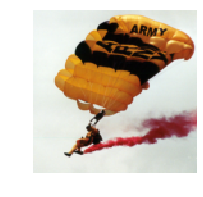

In [ ]:
show_image(il[0])

In [ ]:
img = PIL.Image.open(il.items[0])

Be careful of resampling methods, you can quickly lose some textures!

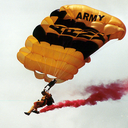

In [ ]:
img.resize((128,128), resample=PIL.Image.ANTIALIAS)

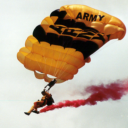

In [ ]:
img.resize((128,128), resample=PIL.Image.BILINEAR)

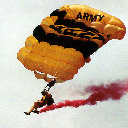

In [ ]:
img.resize((128,128), resample=PIL.Image.NEAREST)

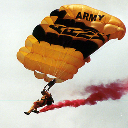

In [ ]:
img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

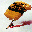

In [ ]:
img.resize((32,32), resample=PIL.Image.NEAREST)

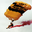

In [ ]:
img.resize((32,32), resample=PIL.Image.ANTIALIAS)

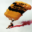

In [ ]:
img.resize((32,32), resample=PIL.Image.BILINEAR)

### Flip

Flip can be done with PIL very fast.

In [ ]:
#export
import random

def show_aug(gen, r=1, c=4, figsize=None):
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for ax in axes.flat:
        ax.imshow(gen())
        ax.axis('off')

In [ ]:
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<0.5 else x

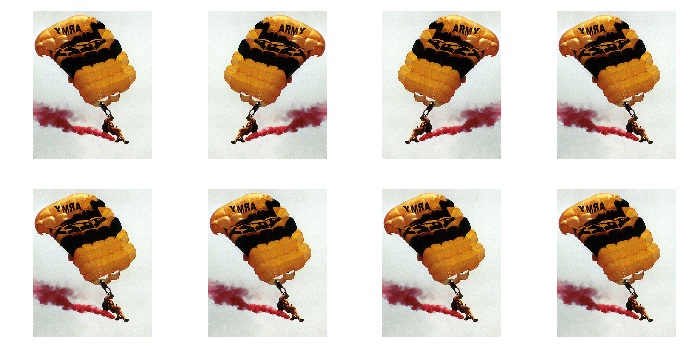

In [ ]:
show_aug(partial(pil_random_flip, img), r=2)

In [ ]:
il1 = get_il(tfms)
il1.items = [il1.items[0]]*64
dl = DataLoader(il1, 8)

In [ ]:
x = next(iter(dl))

Here is a convenience function to look at images in a batch.

In [ ]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))

def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): show_image(xi, ax)

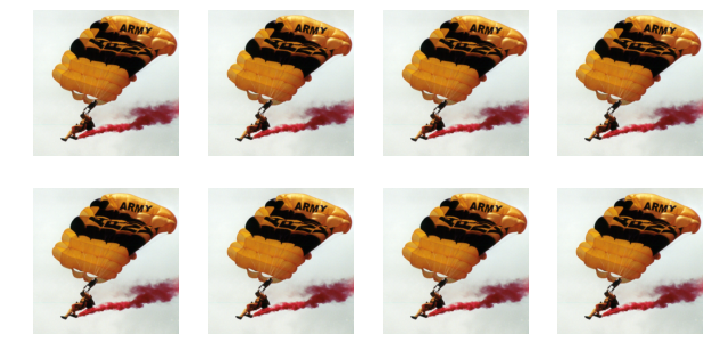

In [ ]:
show_batch(x)

In [ ]:
il1.tfms.append(pil_random_flip)

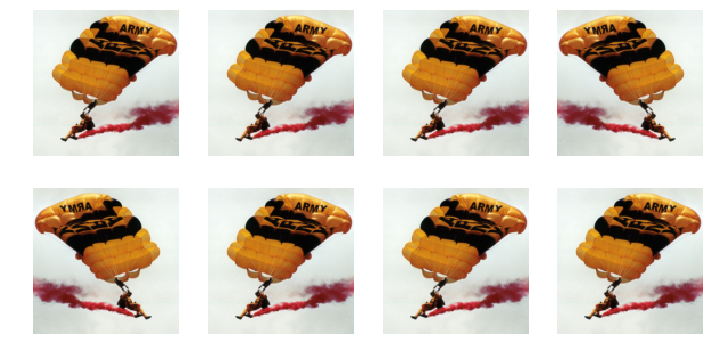

In [ ]:
x = next(iter(dl))
show_batch(x)

In [ ]:
class PilRandomFlip(Transform):
    _order=11
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [ ]:
#export
class PilTransform(Transform): _order=11

class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p=p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [ ]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomFlip(0.8))

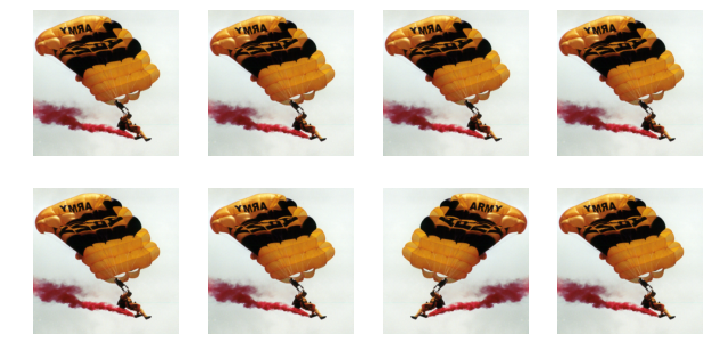

In [ ]:
x = next(iter(dl))
show_batch(x)

In [ ]:
#export
class PilRandomDihedral(PilTransform):
    def __init__(self, p=7/8): self.p=p
    def __call__(self, x):
        if random.random()>self.p: return x
        return x.transpose(random.randint(0,6))

In [ ]:
PIL.Image.FLIP_LEFT_RIGHT,PIL.Image.ROTATE_270,PIL.Image.TRANSVERSE

(0, 4, 6)

In [ ]:
del(il1.tfms[-1])
il1.tfms.append(PilRandomDihedral())

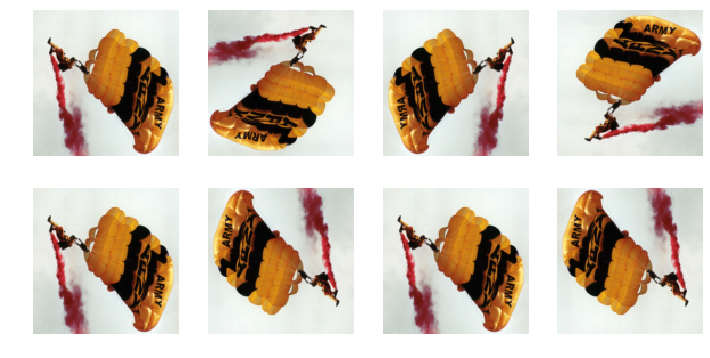

In [ ]:
show_batch(next(iter(dl)))

### Random crop

In [ ]:
img.size

(399, 500)

Regular cropping

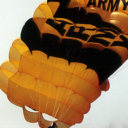

In [ ]:
img.crop((60,60,320,320)).resize((128,128), resample=PIL.Image.BILINEAR)

In [ ]:
cnr2 = (60,60,320,320)
resample = PIL.Image.BILINEAR

In [ ]:
%timeit -n 10 img.crop(cnr2).resize((128,128), resample=resample)

668 µs ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our time budget: aim for 5 mins per batch for imagenet on 8 GPUs. 1.25m images in imagenet. So on one GPU per minute that's `1250000/8/5 == 31250`, or 520 per second. Assuming 4 cores per GPU, then we want ~125 images per second - so try to stay <10ms per image.

More evolved cropping

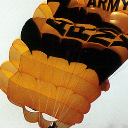

In [ ]:
img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

In [ ]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

583 µs ± 4.72 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
#export
from random import randint

In [ ]:
def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

In [ ]:
class PilRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = self.size if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        left,top = randint(0,x.size[0]-self.crop_size[0]),randint(0,x.size[1]-self.crop_size[1])
        corners = (left, top, left+self.crop_size[0], top+self.crop_size[1])
        return x.transform(self.size, PIL.Image.EXTENT, corners, resample=self.resample)

In [ ]:
il1.tfms = [make_rgb, PilRandomCrop(128, 256), to_byte_tensor, to_float_tensor]

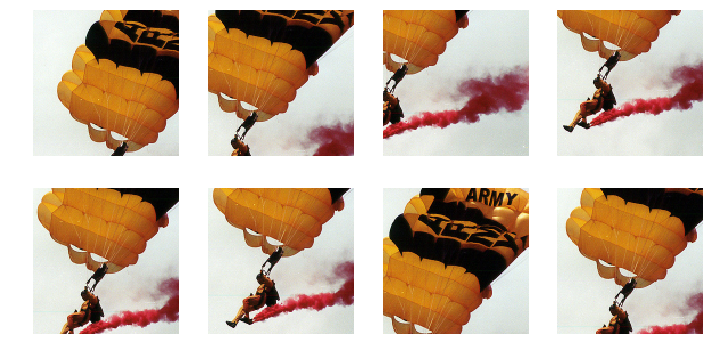

In [ ]:
show_batch(next(iter(dl)))

### Perspective warping

To do perspective warping, we map the corners of the image to new points: for instance, if we want to tilt the image so that the top looks closer to us, the top/left corner needs to be shifted to the right and the top/right to the left. To avoid squishing, the bottom/left corner needs to be shifted to the left and the bottom/right corner to the right. For instance if we have an image with corners in:
```
(60,60,60,280,280,280,280,60)
```
(top/left, bottom/left, bottom/right, top/right) then a warped version is
```
(90,60,30,280,310,280,250,60)
```

We need to solve this [equation](https://web.archive.org/web/20150222120106/xenia.media.mit.edu/~cwren/interpolator/). The equation solver is [gesv](http://www.netlib.org/lapack/explore-html/d7/d3b/group__double_g_esolve_ga5ee879032a8365897c3ba91e3dc8d512.html) from LAPACK (now torch.solve in the nightlies), as implemented in PyTorch.

In [ ]:
from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0])

In [ ]:
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [ ]:
#src  = ((60,60),(60,280),(280,280),(280,60))
targ = ((0,0),(0,128),(128,128),(128,0))
src  = ((90,60),(30,280),(310,280),(250,60))

In [ ]:
img.size

(399, 500)

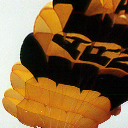

In [ ]:
c = find_coeffs(src, targ)
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=resample)

In [ ]:
%timeit -n 10 warp(img, (128,128), src)

810 µs ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 warp(img, (128,128), src, resample=PIL.Image.NEAREST)

310 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


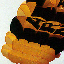

In [ ]:
warp(img, (64,64), src, resample=PIL.Image.BICUBIC)

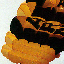

In [ ]:
warp(img, (64,64), src, resample=PIL.Image.NEAREST)

In [ ]:
def uniform(a,b): return a + (b-a) * random.random()

We can add a transform to do this perseptive warping automatically.

In [ ]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.NEAREST): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = self.size if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        up_t,lr_t = uniform(-self.magnitude, self.magnitude),uniform(-self.magnitude, self.magnitude)
        left,top = randint(0,x.size[0]-self.crop_size[0]),randint(0,x.size[1]-self.crop_size[1])
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(self.crop_size).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [ ]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 220, magnitude=0.2), to_byte_tensor, to_float_tensor]

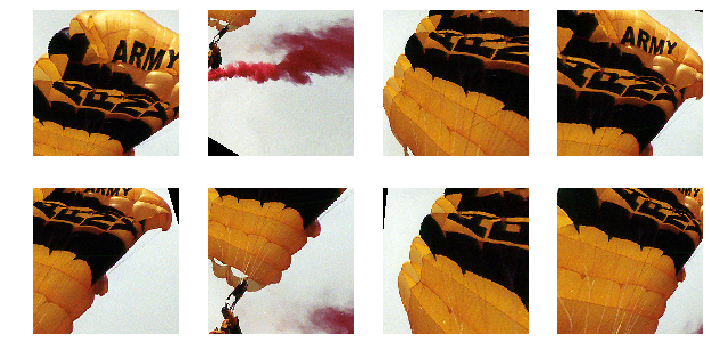

In [ ]:
x = next(iter(dl))
show_batch(x)

Problem is that black padding appears as soon as our target points are outside of the image, so we have to limit the magnitude if we want to avoid that.

In [ ]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = self.size if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        left,top = randint(0,x.size[0]-self.crop_size[0]),randint(0,x.size[1]-self.crop_size[1])
        top_magn = min(self.magnitude, left/self.crop_size[0], (x.size[0]-left)/self.crop_size[0]-1)
        lr_magn  = min(self.magnitude, top /self.crop_size[1], (x.size[1]-top) /self.crop_size[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(self.crop_size).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [ ]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 220, magnitude=0.2), to_byte_tensor, to_float_tensor]

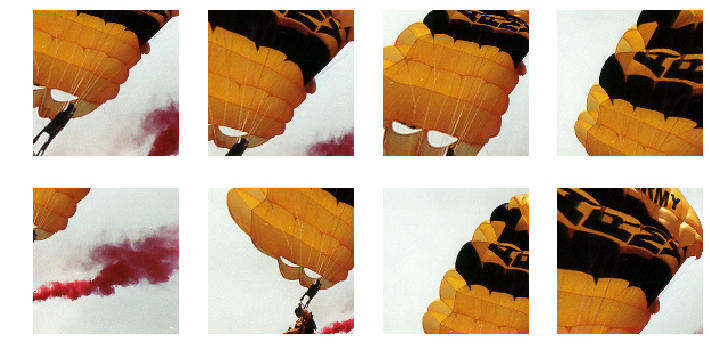

In [ ]:
x = next(iter(dl))
show_batch(x)

### Faster tensor creation

In [ ]:
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_08.make_rgb(item)>),
 (10, <exp.nb_08.ResizeFixed at 0x7f8b6d869cc0>),
 (11, <__main__.PilRandomDihedral at 0x7f8b248d4f98>),
 (20, <function exp.nb_08.to_byte_tensor(item)>),
 (30, <function exp.nb_08.to_float_tensor(item)>)]

In [ ]:
#export
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False))/255.

In [ ]:
%timeit -n 10 to_float_tensor(to_byte_tensor(img))

1.96 ms ± 77.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 np_to_float(img)

762 µs ± 74.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Batch data augmentation

Once we have resized our images so we can batch them together, we can apply more data augmentation on a batch level. For the affine/coord transforms, we proceed like this:
1. generate a grid map of the size of our batch (bs x height x width x 2) that contains the coordinates of a grid of size height x width (this will be the final size of the image, and doesn't have to be the same as the current size in the batch)
2. apply the affine transforms (which is a matrix multiplication) and the coord transforms to that grid map
3. interpolate the values of the final pixels we want from the initial images in the batch, according to the transformed grid map

For 1. and 3. there are PyTorch functions: `F.affine_grid` and `F.grid_sample`. `F.affine_grid` can even combine 1 and 2 if we just want to do an affine transformation.

### Step 1: generate the grid

In [ ]:
dl = DataLoader(il1, 64)

In [ ]:
x = next(iter(dl))

In [ ]:
from torch import FloatTensor

In [ ]:
def affine_grid_cpu(size):
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

In [ ]:
grid = affine_grid_cpu(x.size())

In [ ]:
%timeit -n 10 grid = affine_grid_cpu(x.size())

4.78 ms ± 434 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Coords in the grid go from -1, to 1 (PyTorch convention).

In [ ]:
grid.shape

torch.Size([64, 128, 128, 2])

In [ ]:
grid

tensor([[[[-1.0000, -1.0000],
          [-0.9843, -1.0000],
          [-0.9685, -1.0000],
          ...,
          [ 0.9685, -1.0000],
          [ 0.9843, -1.0000],
          [ 1.0000, -1.0000]],

         [[-1.0000, -0.9843],
          [-0.9843, -0.9843],
          [-0.9685, -0.9843],
          ...,
          [ 0.9685, -0.9843],
          [ 0.9843, -0.9843],
          [ 1.0000, -0.9843]],

         [[-1.0000, -0.9685],
          [-0.9843, -0.9685],
          [-0.9685, -0.9685],
          ...,
          [ 0.9685, -0.9685],
          [ 0.9843, -0.9685],
          [ 1.0000, -0.9685]],

         ...,

         [[-1.0000,  0.9685],
          [-0.9843,  0.9685],
          [-0.9685,  0.9685],
          ...,
          [ 0.9685,  0.9685],
          [ 0.9843,  0.9685],
          [ 1.0000,  0.9685]],

         [[-1.0000,  0.9843],
          [-0.9843,  0.9843],
          [-0.9685,  0.9843],
          ...,
          [ 0.9685,  0.9843],
          [ 0.9843,  0.9843],
          [ 1.0000,  0.9843]],



PyTorch version is slower on the CPU but optimized to go very fast on the GPU

In [ ]:
m = tensor([[1., 0., 0.], [0., 1., 0.]])
theta = m.expand(x.size(0), 2, 3)

In [ ]:
theta.shape

torch.Size([64, 2, 3])

In [ ]:
%timeit -n 10 grid = F.affine_grid(theta, x.size())

7.72 ms ± 321 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 grid = F.affine_grid(theta.cuda(), x.size())

The slowest run took 104.13 times longer than the fastest. This could mean that an intermediate result is being cached.
2.36 ms ± 5.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
def affine_grid(x, size):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    if x.device.type == 'cpu': return affine_grid_cpu(size) 
    m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)
    return F.affine_grid(m.expand(x.size(0), 2, 3), size)

In [ ]:
grid = affine_grid(x, 128)

### Step 2: Affine multiplication

In 2d an affine transformation has the form y = Ax + b where A is a 2x2 matrix and b a vector with 2 coordinates. It's usually represented by the 3x3 matrix
```
A[0,0]  A[0,1]  b[0]
A[1,0]  A[1,1]  b[1]
   0       0     1
```
because then the composition of two affine transforms can be computed with the matrix product of their 3x3 representations.

In [ ]:
from torch import stack,zeros_like,ones_like

In [ ]:
def rotation_matrix(thetas):
    thetas.mul_(math.pi/180)
    rows = [stack([thetas.cos(),             thetas.sin(),             torch.zeros_like(thetas)], dim=1),
            stack([-thetas.sin(),            thetas.cos(),             torch.zeros_like(thetas)], dim=1),
            stack([torch.zeros_like(thetas), torch.zeros_like(thetas), torch.ones_like(thetas)], dim=1)]
    return stack(rows, dim=1)

In [ ]:
thetas = torch.empty(x.size(0)).uniform_(-30,30)

In [ ]:
thetas[:5]

tensor([-22.8904,  21.9159,  19.5148,   0.9064,   1.9623])

In [ ]:
m = rotation_matrix(thetas)

In [ ]:
m.shape, m[:,None].shape, grid.shape

(torch.Size([64, 3, 3]),
 torch.Size([64, 1, 3, 3]),
 torch.Size([64, 128, 128, 2]))

In [ ]:
grid.view(64,-1,2).shape

torch.Size([64, 16384, 2])

In [ ]:
tfm_grid = grid @ m[:,None,:2,:2]

In [ ]:
grid.size()

torch.Size([64, 128, 128, 2])

In [ ]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]

11.9 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2][:,None,None]

17.4 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:,:2,:2]) + m[:,2,:2][:,None]).view(-1, 128, 128, 2)

10.9 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
grid = grid.cuda()
m = m.cuda()

In [ ]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]

135 µs ± 49 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2][:,None,None]

108 µs ± 9.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:,:2,:2]) + m[:,2,:2][:,None]).view(-1, 128, 128, 2)

89 µs ± 9.68 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
def rotation_matrix(thetas):
    thetas.mul_(math.pi/180)
    rows = [stack([thetas.cos(),       thetas.sin(),       zeros_like(thetas)], dim=1),
            stack([-thetas.sin(),      thetas.cos(),       zeros_like(thetas)], dim=1), 
            stack([zeros_like(thetas), zeros_like(thetas), ones_like (thetas)], dim=1)]
    return stack(rows, dim=1)

### Step 3: interpolate

In [ ]:
tfm_grid = torch.bmm(grid.view(64,-1,2), m[:,:2,:2]).view(-1, 128, 128, 2)

In [ ]:
tfm_x = F.grid_sample(x, tfm_grid.cpu())

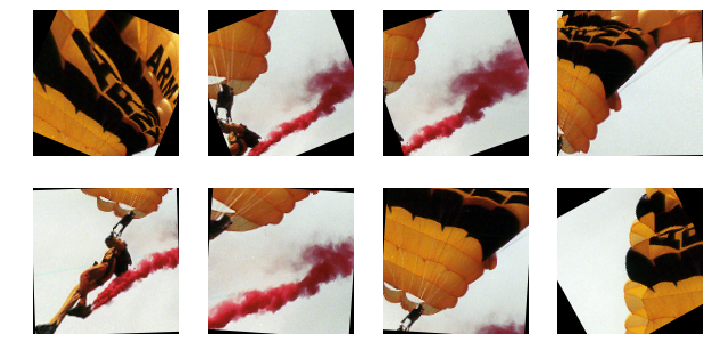

In [ ]:
show_batch(tfm_x, r=2)

In [ ]:
tfm_x = F.grid_sample(x, tfm_grid.cpu(), padding_mode='reflection')

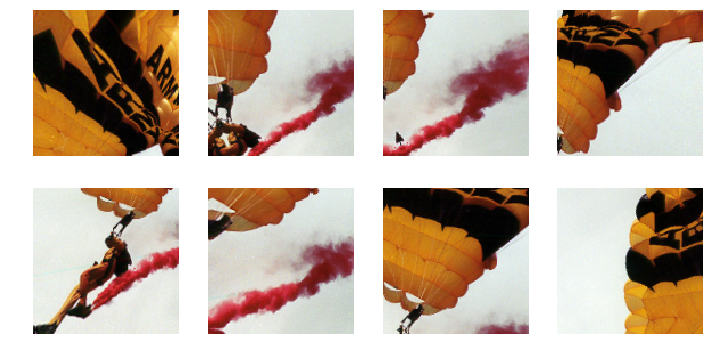

In [ ]:
show_batch(tfm_x, r=2)

### Timing

In [ ]:
def rotate_batch(x, size, degrees):
    grid = affine_grid(x, size)
    thetas = x.new(x.size(0)).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = grid @ m[:,:2,:2].unsqueeze(1) + m[:,2,:2][:,None,None]
    return F.grid_sample(x, tfm_grid)

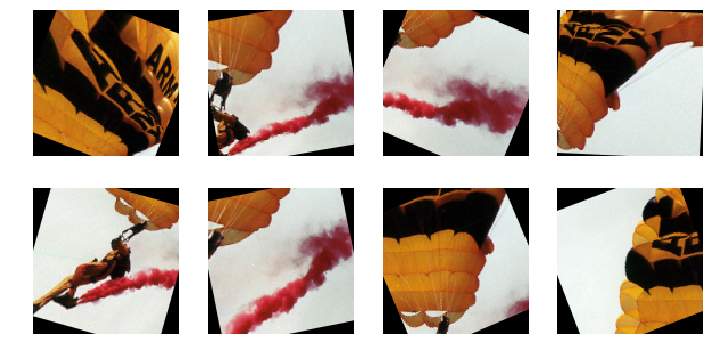

In [ ]:
show_batch(rotate_batch(x, 128, 30), r=2)

In [ ]:
%timeit -n 10 tfm_x = rotate_batch(x, 128, 30)

36.6 ms ± 282 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

6.74 ms ± 482 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Jit version

In [ ]:
from torch import Tensor

In [ ]:
@script
def rotate_batch(x:Tensor, size:int, degrees:float) -> Tensor:
    sz = (x.size(0),x.size(1)) + (size,size)
    idm = torch.zeros(2,3, device=x.device)
    idm[0,0] = 1.
    idm[1,1] = 1.
    grid = F.affine_grid(idm.expand(x.size(0), 2, 3), sz)
    thetas = torch.zeros(x.size(0), device=x.device).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2].unsqueeze(1).unsqueeze(2)
    return F.grid_sample(x, tfm_grid)

In [ ]:
m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)

In [ ]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

7.28 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### affine multiplication with `affine_grid`

In [ ]:
def rotate_batch(x, size, degrees):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    thetas = x.new(x.size(0)).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    grid = F.affine_grid(m[:,:2], size)
    return F.grid_sample(x.cuda(), grid)

In [ ]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

2.36 ms ± 64.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Export

In [ ]:
nb_auto_export()

Converted 10_transforms.ipynb to nb_10.py
